# Low dimensional logistic regression label transfer of variance decomposed Single Cell Data

## Author Notes

* The following tutorial describes a method for integrating data by label transfering based on ridge regulariased logistic regression in low-dimensional space. This approach enables us to fit a model on the annotated training/landscape/reference dataset to predict labels of a new dataset and embed these labels onto neighbourhoods in the prediction data. 

* Logistic regression can (1) be used to classify samples, (2) use different types of data (continuous and descrete measurements)and (3) also be used to assess what variables are useful for classifying samples.

#### Current progress: 
- integrating a latent variable model for neighbourhood construction using factor decomposition. 
- Integration of BIC metric
- Integration of AUC Robustness testing for in classifications made in clusters

# Improvements::

1. Applying PCA to remove multi-collinearity ::
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

Multicollinearity occurs when features (input variables) are highly correlated with one or more of the other features in the dataset. It affects the performance of regression and classification models. PCA (Principal Component Analysis) takes advantage of multicollinearity and combines the highly correlated variables into a set of uncorrelated variables. Therefore, PCA can effectively eliminate multicollinearity between features.
The initial model can be considered as the base model. Then, we’ll apply PCA and build the logistic regression model again. After that, we’ll compare the performance between the base model and this model. Finally, we’ll build a machine learning Pipeline to combine the multiple steps of applying logistic regression with PCA. 

2. Over-sampling using SMOTE (Synthetic Minority Oversampling Technique)
3. Recursive Feature Elimination (Recursive Feature Elimination (RFE) (Univariate feature selection:: Univariate feature selection works by selecting the best features based on univariate statistical tests.) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.)(You can combine both methods: Create PCA components and then run feature selection.)

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

https://stats.stackexchange.com/questions/476308/how-do-i-perform-a-logistic-regression-w-smote


- Compute precision, recall, F-measure and support [from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))]

Interpretation: Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer’s preferred term deposits that were promoted


# Author information

### Created on: 291121; Updated: 050222;
### Author: Issac Goh
### Proof readers/Testers: Anthony Rose

In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

# Only block to edit in LR script

In [100]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/LR_human_gastrulation_ys/"

# Required: Name of second object
data1 = "_ys"
# Provide path to obj1 // prediction/projection data
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A1.210312_lvl5_ys_for_yolk.h5ad"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Required: Name of first object
data2 = "_gastrulation"
# Provide path to obj2 // landscape/training data
Object2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/A1_V1_human_gastrulation.h5ad"
# Provide categorical to join between datasets
cat2 = "sub_cluster"

# Required: LR Model Options
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
sparcity=0.2 #If using LR without optimisation, this controls the sparsity in model
max_iter = 200 #Increase if experiencing max iter issues
l1_ratio = 0.1 #If using elasticnet without optimisation, this controls the ratio between l1 and l2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ["fetal_ids","seq"] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2
theta = 3 

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type. 
subsample_prop = 0.2 # Give this option a proprtion to subsample to(e.g 0.2), if NA given, will subsample to smallest population
subsample_predict = False
subsample_prop_predict = 0.5
remove_non_high_var = False #if model should be trained in solely HVGs
subsample_smote = False

train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

In [10]:
from scipy.stats import norm
counts = np.log10(pd.DataFrame(adata.obs['corr_concat'].value_counts()))
mean = np.mean(counts['corr_concat'])
std = np.std(counts['corr_concat'])
pvals = scipy.stats.norm.sf(counts['cell.labels'], loc=mean, scale=std)
counts['pvals'] = pvals
counts

# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 15
class_out_val = 1000

#df = pd.read_csv('df_imbalanced.csv', encoding='utf-8', engine='python')
samp_strat = dict(zip(list(df.label.unique()),([1000] * len(df.label.unique()))))
# make a new df made of all the columns, except the target class
X = df.loc[:, df.columns != 'label']
y = df.label
sm = SMOTE(samp_strat, k_neighbors=k, random_state=seed)
#sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(X, y)

plt.title('Dataset balanced with synthetic or SMOTEd data ({} neighbors)'.format(k))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X_res.iloc[:, 0], X_res.iloc[:, 1], marker='o', c=y_res, s=25, edgecolor='k', cmap=plt.cm.coolwarm)
plt.show()
df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)

KeyError: 'corr_concat'

# Optional:: Export data from here and perform harmony optimisation prior to continuation, else, use default harmnony theta
-- sil score high between samples and low kbet rejection rate = optimal

# Output from :: Kbet loop with harmony optimisation goes here

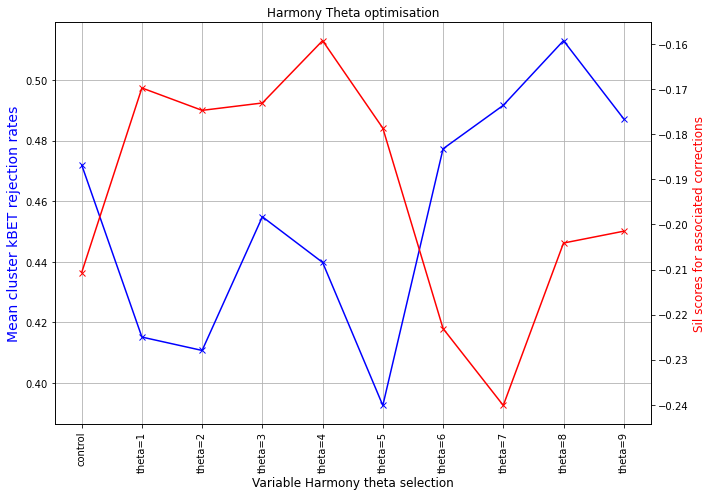

In [34]:
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

# x = kbet_out.iloc[:,0]
# y= kbet_out.iloc[:,1]

# # create figure and axis objects with subplots()
# fig,ax = plt.subplots(figsize = (10,7))
# # make a plot
# ax.plot(x, y, 'bx-', color="blue")
# ax.grid()
# # set x-axis label
# ax.set_xlabel("Variable Harmony theta selection",fontsize=12)
# plt.xticks(rotation=90)

# # set y-axis label
# rand_label = "Mean cluster kBET rejection rates"
# ax.set_ylabel(rand_label,color="blue",fontsize=14)

# # make a plot with different y-axis using second axis object
# ax2=ax.twinx()
# ax2.plot(x, sil.iloc[:,0], 'bx-',color="red")
# mi_label = "Sil scores for associated corrections"
# ax2.set_ylabel(mi_label,color="red",fontsize=12)



# plt.title('Harmony Theta optimisation')
# plt.savefig("./kbet_harmony_theta.pdf",dpi=200)
# #Set X ticks to integer values
# plt.show();

## Combining datasets and Preprocessing
- creates a combined neighbourhood space between both datasets and uses a chosen batch regression technique with pre-chosebn parameters to attempt batch-correction between data

In [ ]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    adata2 =  sc.read(Object2)
    del adata.uns
    del adata2.uns
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")
    
adata2.obs['seq'] = 'ss2'

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
        
adata.var_names_make_unique()
adata2.var_names_make_unique()

# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.filter_cells(adata2, min_genes=200)
sc.pp.filter_genes(adata2, min_cells=3)

#scale indpendently
#Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
#scale by unit variance, clip at >10sd
#sc.pp.scale(adata, zero_center=False, max_value=10, copy=False) #zero_center=True (densifies output)

sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
#sc.pp.scale(adata2, zero_center=False, max_value=10, copy=False) #zero_center=True (densifies output)

if subsample_smote == True:
    from sklearn.datasets import make_classification
    from imblearn.datasets import make_imbalance
    from scipy.sparse import csr_matrix
    index_dic = dict(zip(list(adata.obs[cat1].unique()),list(range(0,len(adata.obs[cat1].unique())))))
    adata.obs['cat_index'] = adata.obs[cat1].map(index_dic)
    cat_indexer = adata.obs['cat_index']
    cat_indexer
    X1 = pd.DataFrame.sparse.from_spmatrix(adata.X)
    Y1 =  adata.obs['cat_index']
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
    #            s=25, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.show()
    # concatenate the features and labels into one dataframe
    df = pd.DataFrame(X1,index = adata.obs.index)
    df.columns = adata.var.index #"PC_" + df.columns.astype(str)
    Y_df = pd.DataFrame(Y1)
    Y_df.columns = ['label']
    df = pd.concat([df, Y_df], axis=1)
    # save the dataset because we'll use it later
    #df.to_csv('df_base.csv', index=False, encoding='utf-8')
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.preprocessing import MinMaxScaler
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as imbpipeline
    from sklearn.pipeline import Pipeline

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=11)

    pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],['scaler', MinMaxScaler()],['classifier', LogisticRegression(random_state=11, max_iter=1000)]])

    stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True, random_state=11)

    param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

    X = df.loc[:, df.columns != 'label']
    y = df.label
    from numpy import mean
    from sklearn.datasets import make_classification
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.tree import DecisionTreeClassifier
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    # Oversample the data by X
    k = 5
    over = SMOTE(sampling_strategy='auto', k_neighbors=k)
    under = RandomUnderSampler('majority',sampling_strategy='auto')
    steps_out = [('under', under),('over', over)]
    pipeline_out = Pipeline(steps=steps_out)
    X_res, y_res = pipeline_out.fit_resample(X, y)
    smote_out = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
    smote_out

# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

# Optional subsampling of training data to 
if(subsample_train == True):
    
    if not(subsample_prop=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop
        data = adata.obs[:]
        grouped = data.groupby(cat1)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat1)
        keep = df.index
        adata = adata[adata.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata.obs
        data = data.sample(frac=1).groupby(cat1).head(min(adata.obs.groupby(cat1).size()))
        keep = data.index
        adata = adata[adata.obs.index.isin(keep)]
        
# Optional subsampling of training data to 
if(subsample_predict == True):
    if not(subsample_prop_predict=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop_predict
        data = adata2.obs[:]
        grouped = data.groupby(cat2)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat2)
        keep = df.index
        adata2 = adata2[adata2.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata2.obs
        data = data.sample(frac=1).groupby(cat2).head(min(adata.obs.groupby(cat2).size()))
        keep = data.index
        adata2 = adata2[adata2.obs.index.isin(keep)]

# Create a common batch column and do simple sanity check for batch variables
if not((batch_correction == "False") and (len(batch)>1)):
    print("Batch correction option detected, proceeding to format batch variables")
    batch_var = "lr_batch"
    adata.obs["lr_batch"] = adata.obs[batch[0]]
    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=False, max_value=None, copy=False) #zero_center=True (densifies output)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"


# Now compute PCA
sc.pp.pca(adata, n_comps=100, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

# Batch correction options
# The script will test later which Harmony values we should use
if (batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=100)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    batch_var = "lr_batch"
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
    del adata_hm
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")
sc.tl.umap(adata)

# Check umap output

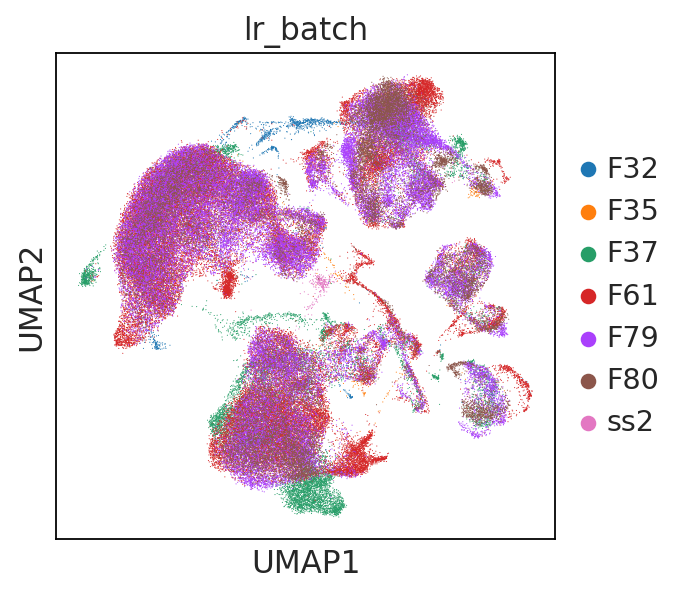

In [8]:
sc.pl.umap(adata,color = ['lr_batch'])

## Multinomial Logistic regression function to train data set and transfer labels
- multiclass case -> training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’.
- https://machinelearningmastery.com/cross-entropy-for-machine-learning/
- Entropy provides a measure of the average amount of information needed to represent an event drawn from a probability distribution for a random variable.
- cross-entropy can be thought to calculate the total entropy between the probability distributions.
- elastic_net_penalty = (alpha * l1_penalty) + ((1 – alpha) * l2_penalty)
- For example, an alpha of 0.5 would provide a 50 percent contribution of each penalty to the loss function. An alpha value of 0 gives all weight to the L2 penalty and a value of 1 gives all weight to the L1 penalty.
- A default value of lambda = 1.0 is used to use the fully weighted penalty; a value of 0 excludes the penalty. Very small values of lambda, such as 1e-3 or smaller, are common.
- elastic_net_loss = loss + (lambda * elastic_net_penalty)


In [102]:
def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter)
    
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear',multi_class = 'ovr' ) # one-vs-rest
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'multinomial')

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        predict_label = train_label[subset_predict]
        train_label = train_label[subset_train]
        train_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_train].index))]
        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        predict_label = train_label[subset_predict]
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])
    return lr, adata, predict

# Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

# Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

Tune penalties used in the model

### Warning! This takes a very long time with big data! Suggest using a small subset of data to test, else skip and use a predefined l1 ratio
- Use the GridsearchCV class qwith a grid of values defined
- Ignore the sign; the library makes the MAE negative for optimization purposes.

- We can see that the model assigned an alpha weight of 0.01 to the penalty and focuses exclusively on the L2 penalty.

- Rank models by Mean absolute error: The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or L1-norm loss.

In [ ]:
# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"
# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

In [13]:
# Subset and create samller dataset for hyperparam tuning
#train_x = 'X_pca'
tune_train_x = train_x[:]
prop = 0.2
data = adata.obs
grouped = data.groupby(common_cat)
df = grouped.apply(lambda x: x.sample(frac=prop))
df = df.droplevel(common_cat)
keep = df.index
adata_tuning = adata[adata.obs.index.isin(keep)]

df = df.loc[df[common_cat].isin(group1)]
tune_subset_train = np.array(adata_tuning.obs[common_cat].isin(group1))

tune_train_label = df.loc[df[common_cat].isin(group1),[common_cat]].values
tune_train_x = adata_tuning.obsm[tune_train_x]
tune_train_x = tune_train_x[tune_subset_train, :]

# Create a training class index
#train_indexes = dict(zip(set(group1),set([str(x) for x in list(range(0,len(group1)))])))
#df['train_classes'] = df[common_cat].astype(str).map(train_indexes)
#tune_train_label = df.loc[df[common_cat].isin(group1),['train_classes']].values

model = LogisticRegression(penalty = penalty, max_iter =  max_iter, dual=False,solver = 'saga', multi_class = 'multinomial',l1_ratio=1)
model.fit(X,y)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=1, max_iter=200, multi_class='multinomial',
                   penalty='elasticnet', solver='saga')

In [ ]:
from numpy import arange
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

## tune regularization for multinomial logistic regression
X = tune_train_x
y = tune_train_label

# define model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LogisticRegression(penalty = penalty, max_iter =  max_iter, dual=False,solver = 'saga', multi_class = 'multinomial')

# define grid
grid = dict()
grid['C'] = [0.0, 1.0]
grid['l1_ratio'] = arangethe grid was specified with (0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [ ]:
lr, adata, predict = LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted')
model = lr

In [ ]:
predict = lr.predict(predict_x)
predict_proba = lr.predict_proba(predict_x)
predict

In [ ]:
dir(lr)
lr.intercept_
lr.coef_
lr.classes_

In [ ]:
lr.intercept_

# Repeated k-Fold Cross-Validation for Model Evaluation
-https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

# Weighted F1 and precision recall
-https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

In [ ]:
## Report accuracy score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model = lr

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Report Precision score
metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=3,output_dict=True))).T

cm = confusion_matrix(train_label, model.predict(train_x))
#cm = confusion_matrix(train_label, model.predict_proba(train_x))

df_cm = pd.DataFrame(cm, index = lr.classes_,
                  columns = lr.classes_)
df_cm = (df_cm / df_cm.sum(axis=0))*100
plt.figure(figsize = (20,15))
sn.set(font_scale=1) # for label size
pal = sns.diverging_palette(240, 10, n=10)
plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)

#Plot precision recall and recall
table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
rowLabels=metric.index,
colLabels=metric.columns,
cellLoc = 'center', rowLoc = 'center',
loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
table.scale(1, 2)
table.set_fontsize(16)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=pal) # font size
print(metrics.classification_report(train_label, model.predict(train_x), digits=3))

# Model predictions

In [ ]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X[:2, :])
clf.score(X, y)

In [ ]:
model.predict(predict_x)

In [ ]:
model = lr
pred_out = pd.DataFrame(model.predict(predict_x),columns = ['predicted'],index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out['orig_labels'] = predict_label
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out = pred_out.join(proba)
pred_out

In [ ]:
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
#np.log(proba)
proba

In [ ]:
pred_out = pd.DataFrame(model.predict(predict_x),columns = ['predicted'],index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out['orig_labels'] = predict_label
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out = pred_out.join(proba)
pred_out

# Median prediction probabilities

In [ ]:
pred_out

In [ ]:
pred_out.loc[:, pred_out.columns != 'predicted'].sum(axis=0)

In [ ]:
pred_out

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').mean()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.5)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})

plt.ylabel("Original labels")
plt.xlabel("Training labels")
plt.savefig('./ver5_lr_model_means_subclusters.pdf',dpi=300)

In [ ]:
 # Get aggregagted
key_add = 'orig_labels'
pred_out[key_add] = pred_out[key_add].astype(str)
pred_out[key_add]  = pred_out[key_add].str.replace('_\d+_','_').astype(str)

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').mean()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.5)
crs_tbl = crs_tbl.T
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")
plt.savefig('./ver5_lr_model_means_clusters.pdf',dpi=300)

In [ ]:
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()

In [ ]:


train_label = adata.obs[common_cat].values
predict_label = train_label[subset_predict]

X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X[:2, :])
clf.score(X, y)

pred_out = pd.DataFrame(model.predict(predict_x),columns = ['predicted'],index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out['orig_labels'] = predict_label
proba = pd.DataFrame(model.predict_proba(predict_x),columns = lr.classes_,index = adata.obs.index[adata.obs[common_cat].isin(group2)])
pred_out = pred_out.join(proba)
pred_out

model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').mean()
model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
model_mean_probs = model_mean_probs*100
model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crs_tbl = model_mean_probs.copy()
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")

In [ ]:
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)
# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal,  annot=True,vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Original labels")
plt.xlabel("Training labels")

In [ ]:
pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels')

In [ ]:
crs_tbl.to_csv('./med_lr_probs.csv')

# Model Coefficients
- https://www.datasklr.com/logistic-regression/multinomial-logistic-regression
-The interpretation of the exponentiated coefficients is for a single unit change in the predictor variable, the odds will be multiplied by a factor indicated by the exponent of the beta coefficient, given that all other variables are held constant.  For example, the first variable is LENGTH with a value of 0.038.  This means  that if length increases by one unit the odds of being female is 3.8% compared to the status when length did not increase by one unit. A generic output looks looks something like this (the below is based on infants!)

# Get Model prediction output ranked genes
# Add PC coeff as well
-Standardized coefficients represent the mean change in the response given a one standard deviation change in the predictor.

- plotting multinomial lr https://scikit-learn.org/dev/auto_examples/linear_model/plot_logistic_multinomial.html

In [68]:
# Export top genes for each PC loading
coeff = pd.DataFrame(model.coef_,index = lr.classes_)
df_loadings = pd.DataFrame(adata.varm['PCs'], index=adata.var_names)
df_rankings = pd.DataFrame((-1 * df_loadings.values).argsort(0).argsort(0), index=df_loadings.index, columns=df_loadings.columns)
coeff_rankings = (pd.DataFrame((-1 * coeff.T.values).argsort(0).argsort(0), index=coeff.T.index, columns=coeff.T.columns)).T

# get top loadings for each classification
# Use Cumulative distribution to determine feature importance
ranking_genes = pd.DataFrame(columns = ['class','x_pc','top_loadings','loading_val'])
for classes in coeff_rankings.index:
    print(classes)
    class_ranking = pd.DataFrame(coeff_rankings.T.loc[: , classes])
    class_ranking = class_ranking.iloc[:,0].sort_values().head(3)
    for comps in class_ranking.index:
        print(comps)
        genes = list(df_rankings[comps].sort_values().head(15).index)
        compile_classes = pd.DataFrame(columns = ranking_genes.columns)
        compile_classes.top_loadings = genes
        compile_classes.x_pc = comps
        compile_classes['class'] = classes
        compile_classes['loading_val'] = df_loadings.loc[df_loadings.index.isin(genes),comps].sort_values(ascending=False).values
        ranking_genes = pd.concat([ranking_genes,compile_classes])
        U = np.mean(df_loadings[comps])
        std = np.std(df_loadings[comps])
        med =  np.median(df_loadings[comps])
        mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
        pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
        pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=2*mad)
        df_loadings[str(comps) +'_pval'] = pvals

ranking_genes.to_csv('lr_features_sig.csv')
#plt.plot(coeff.iloc[0,:], coeff.iloc[0,:] + 0, '-g')
#plt.axvline(x=-0.36914894,color='blue')
#plt.axvline(x=-0.36914894,color='blue')

AEC_ys
13
1
2
CMP_ys
32
30
27
DC2_ys
41
4
10
DC_precursor_ys
11
22
21
Early_Erythroid_ys
52
79
42
Endoderm_ys
3
28
43
Eo_Baso_Mast_precursor_ys
25
19
6
Eo_Basophil_ys
25
26
19
Erythroid_ys
6
2
14
Fibroblast_ys
0
5
14
HE_ys
2
13
97
HSPC_1_ys
11
1
20
HSPC_2_ys
10
20
31
ILC_precursor_ys
23
10
11
Immature_EC_ys
2
16
24
LMPP_ys
10
36
29
Lymphoid_progenitor_ys
23
22
10
MEMP_ys
60
6
12
MK_ys
7
62
5
MOP_ys
32
6
27
Macrophage_ys
1
6
22
Mast_cell_ys
25
6
51
Mesothelium_ys
9
0
17
Microglia_ys
1
3
21
Monocyte_Macrophage_ys
16
3
33
Monocyte_ys
24
16
18
NK_ys
38
90
22
Neutrophil_precursor_ys
36
25
32
Pre_Macrophage_ys
15
23
1
Prolif_AEC_ys
13
10
7
Prolif_Sinusoidal_EC_ys
2
10
40
Promonocyte_ys
15
14
54
Sinusoidal_EC_ys
2
16
1
Smooth_Muscle_ys
0
5
14
VWF_EC_ys
20
16
2


# Plot these genes

In [70]:
pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])

,class,x_pc,top_loadings,loading_val
0,AEC_ys,13,GJA5,0.254285
1,AEC_ys,13,IL33,0.232750
2,AEC_ys,13,TMEM100,0.204895
0,AEC_ys,1,AIF1,0.078790
1,AEC_ys,1,LAPTM5,0.078590
...,...,...,...,...
13,VWF_EC_ys,16,AREG,0.070373
14,VWF_EC_ys,16,UPP1,0.069793
12,VWF_EC_ys,2,CD93,0.094238
13,VWF_EC_ys,2,ADGRL4,0.092574


In [71]:
ranking_genes.groupby(['class','x_pc']).head(5)
ranking_genes.groupby(['class','x_pc']).tail(5)

,class,x_pc,top_loadings,loading_val
10,AEC_ys,13,LTBP4,0.106285
11,AEC_ys,13,EMP1,0.094575
12,AEC_ys,13,EFNB2,0.092828
13,AEC_ys,13,SLC1A4,0.091128
14,AEC_ys,13,AQP1,0.087766
...,...,...,...,...
10,VWF_EC_ys,2,PECAM1,0.097085
11,VWF_EC_ys,2,APLNR,0.096024
12,VWF_EC_ys,2,CD93,0.094238
13,VWF_EC_ys,2,ADGRL4,0.092574


In [72]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()

In [ ]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()
predict_grp = adata[adata.obs[common_cat].isin(group1)]
counts = (pd.DataFrame(predict_grp.obs['corr_concat'].value_counts()))
#predict_grp = predict_grp[predict_grp.obs.index.isin(predict_grp.obs.groupby('predicted').head(100).index)]
sc.pl.tracksplot(predict_grp, plot_genes, groupby='corr_concat', dendrogram=True,save = 'trackspot')

In [ ]:
rank = pd.concat([ranking_genes.groupby(['class','x_pc']).head(3),ranking_genes.groupby(['class','x_pc']).tail(3)])
plot_genes =  rank.groupby(['class'])['top_loadings'].agg(lambda grp: list(grp)).to_dict()

In [ ]:
predict_grp = adata[adata.obs[common_cat].isin(group2)]
counts = (pd.DataFrame(predict_grp.obs['predicted'].value_counts()))
#predict_grp = predict_grp[predict_grp.obs.index.isin(predict_grp.obs.groupby('predicted').head(100).index)]
sc.pl.tracksplot(predict_grp, plot_genes, groupby='corr_concat', dendrogram=True,save = 'trackspot')

In [ ]:
ranking_genes.to_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/lr_sig_feature_usage.csv')

# Get genes conserved between matched cellstates and differential expression within combined embedding for single classes of cells

In [ ]:
# Get conserved expression
save = 'endoderm_mouse_human_conserved.csv'
celltypes = ['ExE endoderm_4_mouse_gastrulation','Endoderm_ys']
celltype_rank = ranking_genes[ranking_genes['class'].isin(celltypes)]
celltype_rank.columns = ['cluster','xpca','gene','logfc']
celltype_rank.to_csv(save)

In [ ]:
celltype_rank

In [ ]:
adata.obs['species']

In [ ]:
# Get differential
key_add = 'de_unclust'
adata.obs[key_add] = adata.obs['corr_concat'].astype(str)
adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add]  = adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add].str.replace('_\d+_','_').astype(str)
list(adata.obs.loc[adata.obs['species'].isin(['Mouse']),key_add].unique())

In [ ]:
keep_classes = ['ExE endoderm_mouse_gastrulation','Endoderm_ys']
adata_deg = adata[adata.obs[key_add].isin(keep_classes)]

sc.tl.rank_genes_groups(adata_deg, key_add, method='wilcoxon',groups=keep_classes,n_genes=500)
sc.pl.rank_genes_groups(adata_deg, n_genes=50, sharey=False)

result = adata_deg.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)

DE_name ="./mouse_human_endoderm"
DE.to_csv(DE_name)

103


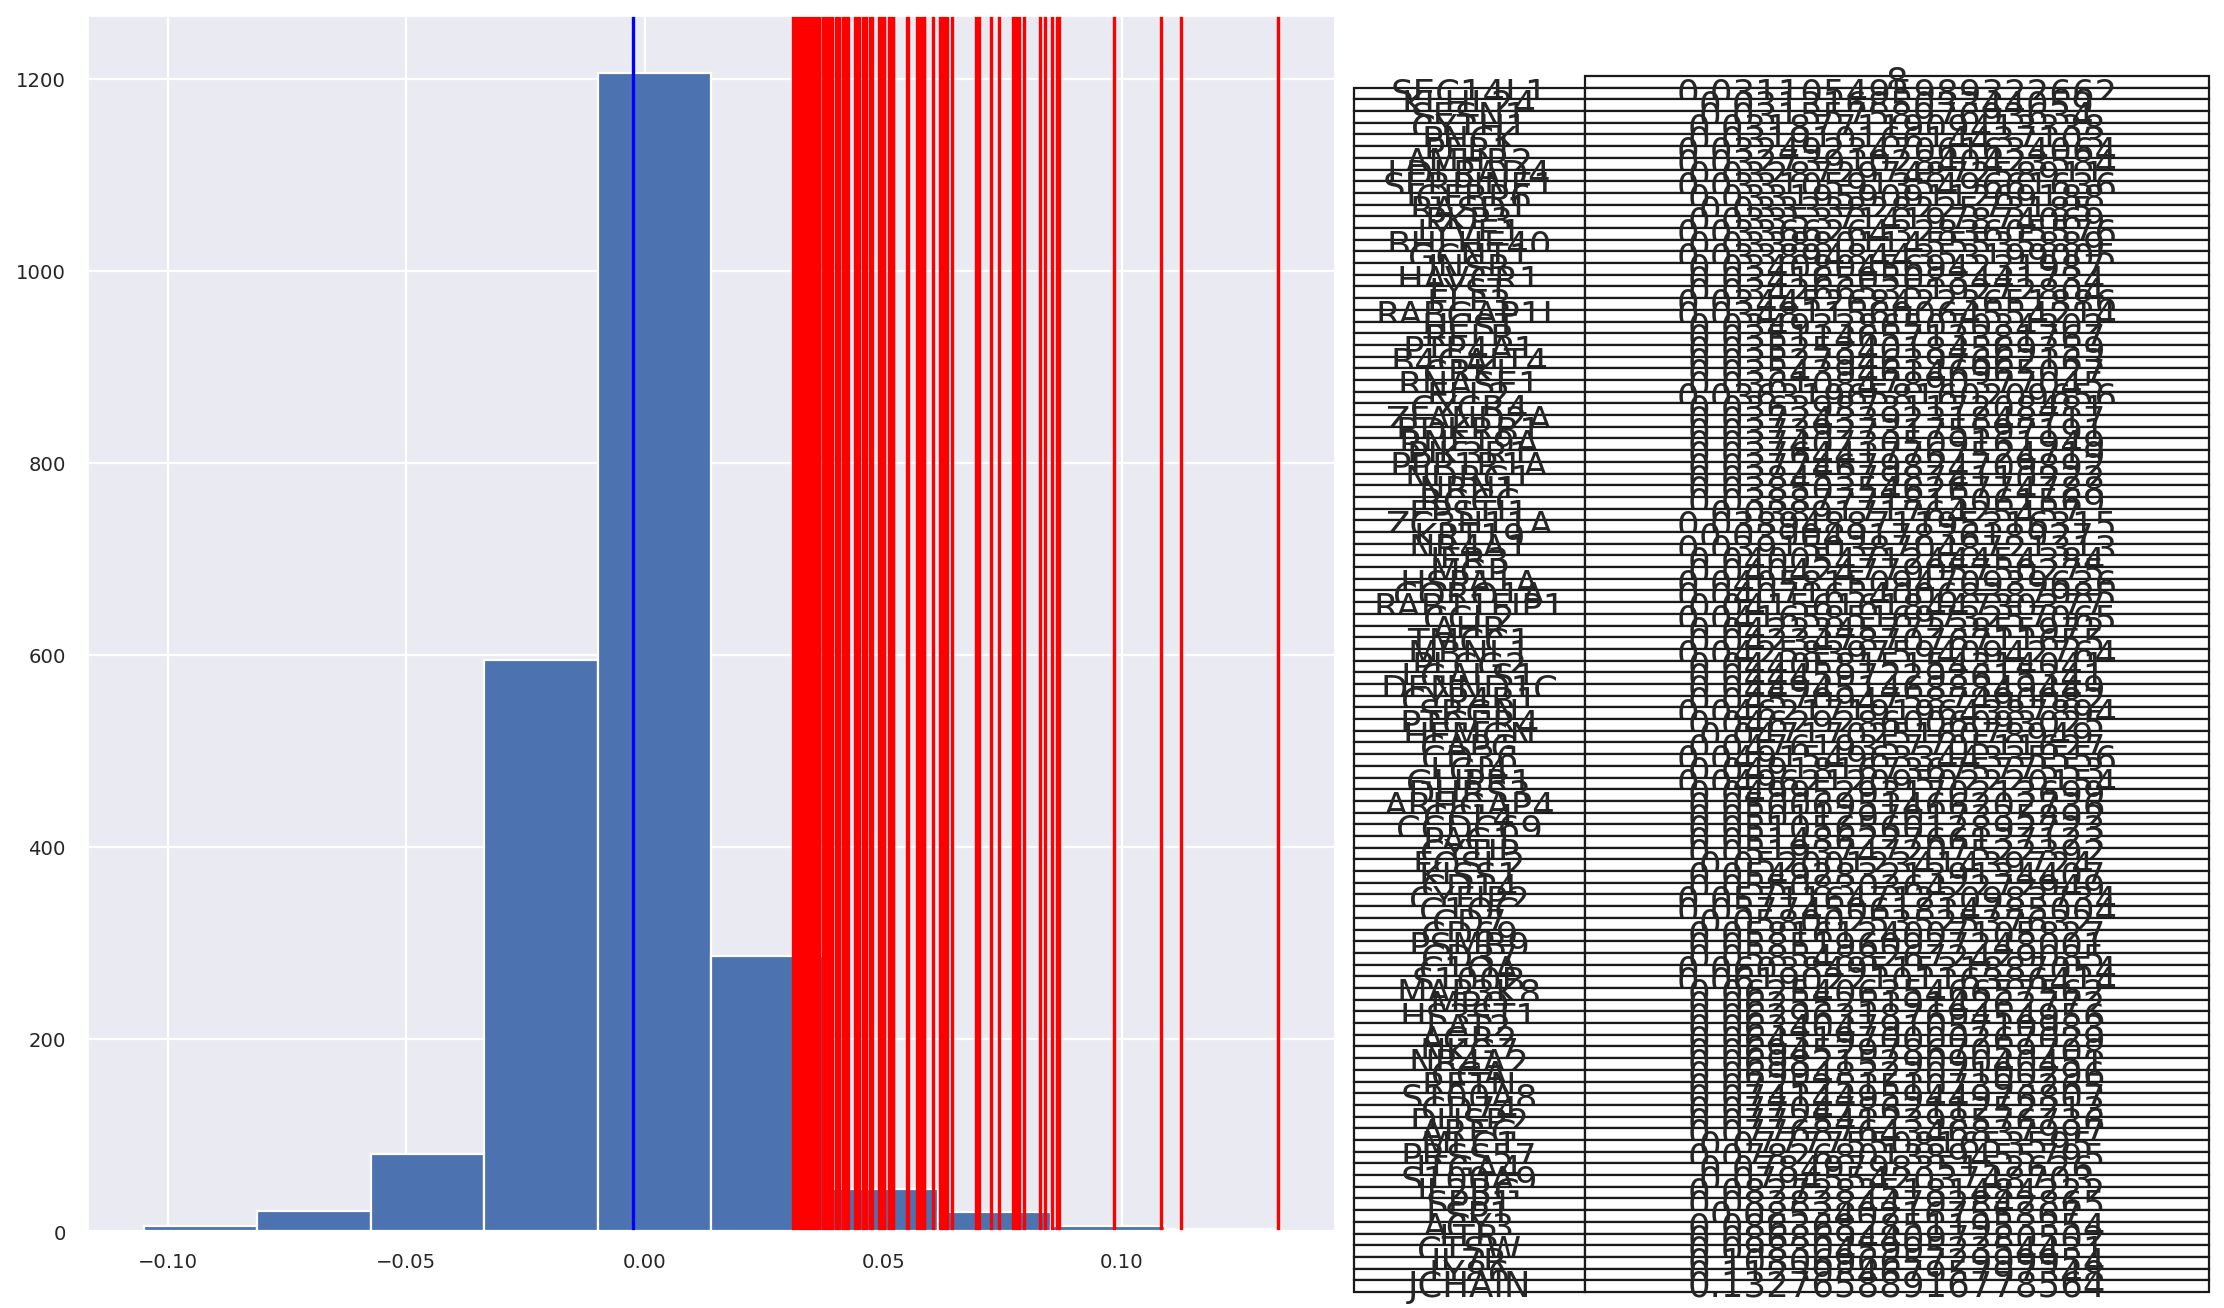

In [40]:
U = np.mean(df_loadings[comps])
std = np.std(df_loadings[comps])
med =  np.median(df_loadings[comps])
mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=2*mad)
#pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
df_loadings[str(comps) +'_pval'] = pvals
plt.hist(df_loadings[comps])
for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
    plt.axvline(x=i,color='red')
plt.axvline(x=med,color='blue')
#plt.axvline(x=med,color='pink')
df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))
#Plot precision recall and recall
plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values())
table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
rowLabels=plot_loading.index,
colLabels=plot_loading.columns,
cellLoc = 'center', rowLoc = 'center',
loc='right', bbox=[1.2, -0.05, 0.5,1])
table.scale(1, 2)
table.set_fontsize(16)

In [ ]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

# Marker gene overlap to rank conserved genes

### Calculate an overlap score between data-deriven marker genes and provided markers 
### Marker gene overlap scores can be quoted as overlap counts, overlap coefficients, or jaccard indices. The method returns a pandas dataframe which can be used to annotate clusters based on marker gene overlaps.

In [ ]:
# Grab marker genes that overlap between top gene loadings in each PCA used for predictions

In [ ]:
scanpy.tl.marker_gene_overlap(adata, reference_markers, *, key='rank_genes_groups', method='overlap_count', normalize=None, top_n_markers=None, adj_pval_threshold=None, key_added='marker_gene_overlap', inplace=False)

# Regress out effect of gene predictions dervied from PCA

In [ ]:
dc_class = ranking_genes[ranking_genes['class'].isin(['DC_YS_main_training'])]

pca = pd.DataFrame(adata.obsm['X_pca'])
regress_ind = list(dc_class['x_pc'].unique())
regress_ind_obs = pca[regress_ind]
regress_ind = ['regress-pc_' + str(s) for s in regress_ind]
regress_ind_obs.columns = regress_ind
adata.obs[regress_ind] = regress_ind_obs.values
adata.obs[regress_ind]
sc.pp.regress_out(adata,keys = regress_ind)

## Optional Clustering 

In [ ]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [ ]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [ ]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

### Heatmap showing cells in predicted clusters

In [ ]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions_consensus.pdf")
crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [ ]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
prop

In [ ]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf")

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf")

In [ ]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

In [ ]:
# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))